In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet, LogisticRegression

#path = 'ncaam-march-mania-2021/MDataFiles_Stage1/'
path = 'ncaam-march-mania-2021/MDataFiles_Stage2/'

In [2]:
season_detailed = pd.read_csv(path+'MRegularSeasonDetailedResults.csv')

In [3]:
season_detailed.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [4]:
season_detailed['Score_Diff'] = season_detailed['WScore'] - season_detailed['LScore']

In [5]:
num_win = season_detailed.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [6]:
num_loss = season_detailed.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [7]:
scoring_win = season_detailed.groupby(['Season', 'WTeamID']).mean().reset_index()
scoring_win = scoring_win[['Season','WTeamID','Score_Diff','WFGM', 'WFGA', 'WFGM3', 'WFGA3', 
                           'WFTM', 'WFTA', 'WOR', 'WDR','WAst', 'WTO', 'WStl', 'WBlk', 'WPF']].rename(columns={'WTeamID':'TeamID','Score_Diff':'Win_Score_Diff'})

In [8]:
scoring_loss = season_detailed.groupby(['Season', 'LTeamID']).mean().reset_index()
scoring_loss = scoring_loss[['Season','LTeamID','Score_Diff','LFGM', 'LFGA', 'LFGM3', 'LFGA3',
                             'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']].rename(
    columns={'LTeamID':'TeamID','Score_Diff':'Loss_Score_Diff'})

In [9]:
df_features_season_w = season_detailed.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = season_detailed.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [10]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [11]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(scoring_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(scoring_loss, on=['Season', 'TeamID'], how='left')

In [12]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['Win_Score_Diff'] - 
    df_features_season['NumLosses'] * df_features_season['Loss_Score_Diff'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [13]:
df_features_season.fillna(0, inplace=True)

In [14]:
df_features_season['FGM'] = (df_features_season['WFGM'] + df_features_season['LFGM'])/2
df_features_season['FGA'] = (df_features_season['WFGA'] + df_features_season['LFGA'])/2
df_features_season['FGM3'] = (df_features_season['WFGM3'] + df_features_season['LFGM3'])/2
df_features_season['FGA3'] = (df_features_season['WFGA3'] + df_features_season['LFGA3'])/2
df_features_season['FTM'] = (df_features_season['WFTM'] + df_features_season['LFTM'])/2
df_features_season['FTA'] = (df_features_season['WFTA'] + df_features_season['LFTA'])/2
df_features_season['OR'] = (df_features_season['WOR'] + df_features_season['LOR'])/2
df_features_season['DR'] = (df_features_season['WDR'] + df_features_season['LDR'])/2
df_features_season['Ast'] = (df_features_season['WAst'] + df_features_season['LAst'])/2
df_features_season['TO'] = (df_features_season['WTO'] + df_features_season['LTO'])/2
df_features_season['Stl'] = (df_features_season['WStl'] + df_features_season['LStl'])/2
df_features_season['Blk'] = (df_features_season['WBlk'] + df_features_season['LBlk'])/2
df_features_season['PF'] = (df_features_season['WPF'] + df_features_season['LPF'])/2

In [15]:
df_features_season

,Season,TeamID,NumWins,NumLosses,Win_Score_Diff,WFGM,WFGA,WFGM3,WFGA3,WFTM,...,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,12.0,16.0,15.583333,22.583333,40.000000,10.000000,21.583333,13.583333,...,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667
1,2003,1103,13.0,14.0,9.384615,30.000000,55.384615,5.461538,14.384615,22.307692,...,16.013736,19.153846,26.032967,9.763736,19.980769,15.310440,12.626374,7.260989,2.315934,19.873626
2,2003,1104,17.0,11.0,13.176471,25.823529,58.352941,7.058824,20.823529,16.000000,...,19.593583,14.545455,20.491979,13.582888,23.251337,11.590909,13.347594,6.435829,3.679144,18.462567
3,2003,1105,7.0,19.0,13.000000,25.571429,61.857143,9.142857,22.428571,19.142857,...,21.293233,16.597744,23.067669,13.838346,23.981203,14.954887,18.447368,9.932331,2.052632,19.977444
4,2003,1106,13.0,15.0,10.384615,24.769231,53.846154,5.846154,15.923077,12.923077,...,17.528205,10.794872,16.751282,12.317949,24.133333,11.766667,17.079487,8.425641,3.184615,18.192308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,9.0,9.0,9.222222,25.888889,53.000000,7.111111,21.777778,12.111111,...,22.111111,11.055556,16.666667,5.777778,22.111111,12.000000,13.000000,8.000000,3.777778,7.666667
6530,2021,1468,11.0,7.0,13.636364,28.363636,55.181818,6.636364,18.454545,12.636364,...,16.655844,11.389610,15.305195,6.487013,19.318182,15.025974,10.889610,6.448052,1.993506,2.961039
6531,2021,1469,6.0,13.0,4.833333,25.833333,59.166667,6.833333,19.833333,18.166667,...,19.724359,15.891026,21.288462,7.634615,23.339744,14.576923,14.564103,6.897436,1.948718,4.051282
6532,2021,1470,5.0,10.0,12.800000,24.000000,50.800000,5.800000,12.800000,15.200000,...,14.150000,14.600000,19.150000,4.250000,20.800000,12.100000,10.200000,6.600000,2.200000,8.800000


In [16]:
df_features_season = df_features_season.drop(['WFGM','WFGA','WFGM3','WFGA3','WFTM','WFTA','WOR','WDR','WAst','WTO','WStl','WBlk','WPF','LFGM','LFGA','LFGM3','LFGA3','LFTM','LFTA','LOR','LDR','LAst','LTO','LStl','LBlk','LPF'],axis=1)

<Figure size 1440x864 with 0 Axes>

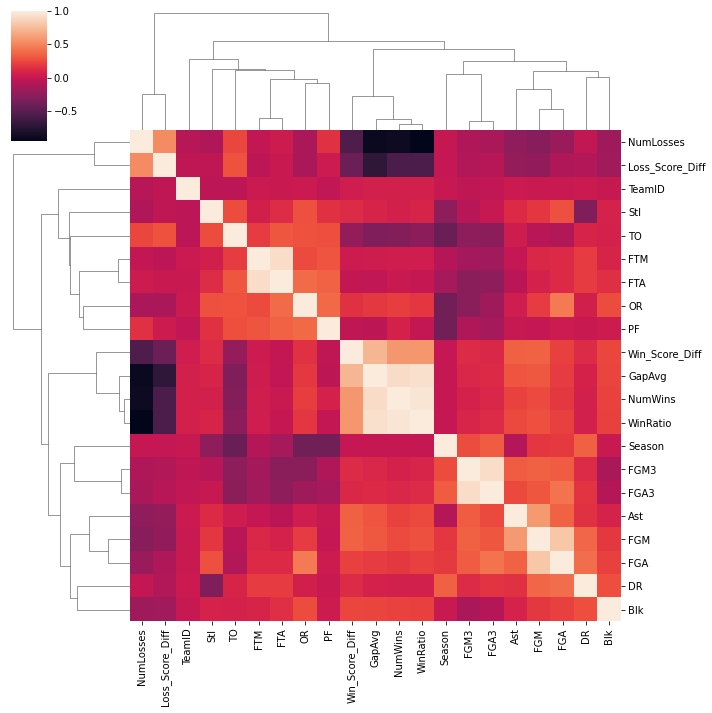

In [17]:
plt.figure(figsize=(20,12))
sns.clustermap(df_features_season.corr())

In [18]:
df_features_season.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6534 entries, 0 to 6533
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Season           6534 non-null   int64  
 1   TeamID           6534 non-null   int64  
 2   NumWins          6534 non-null   float64
 3   NumLosses        6534 non-null   float64
 4   Win_Score_Diff   6534 non-null   float64
 5   Loss_Score_Diff  6534 non-null   float64
 6   WinRatio         6534 non-null   float64
 7   GapAvg           6534 non-null   float64
 8   FGM              6534 non-null   float64
 9   FGA              6534 non-null   float64
 10  FGM3             6534 non-null   float64
 11  FGA3             6534 non-null   float64
 12  FTM              6534 non-null   float64
 13  FTA              6534 non-null   float64
 14  OR               6534 non-null   float64
 15  DR               6534 non-null   float64
 16  Ast              6534 non-null   float64
 17  TO            

In [19]:
df_features_season.to_csv('Detailed_Data.csv',index=False)